In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir("drive/MyDrive/LA")
!pwd

/content/drive/MyDrive/LA


# Data Aggregation

**ASVspoof2019_LA_asv_protocols** 

**ASVspoof2019_LA_asv_scores**

**ASVspoof2019_LA_cm_protocols** - file list
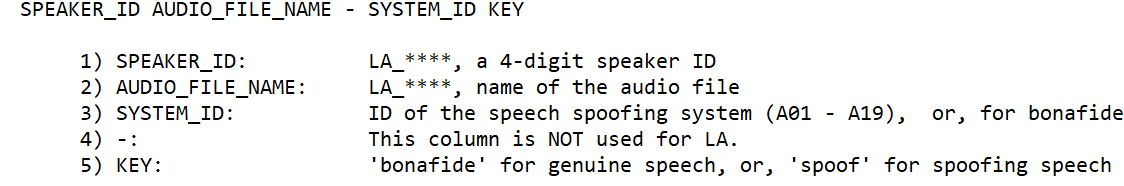
**ASVspoof2019_LA_dev** - audio files for development - "LA_D_*.flac" - dev = validation set

**ASVspoof2019_LA_eval** - audio files for evaluation - "LA_E_*.flac" - eval = test set

**ASVspoof2019_LA_train** - audio files for training - "LA_T_*.flac"

sampling rate is 16 kHz, and stored in 16-bit

In [3]:
import pandas as pd
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
from tqdm import tqdm
import time
import torch

read all dateframes from txt file

In [4]:
df_dev = pickle.load(open("dev_df_pickled", "rb"))
print("dev dataframe unpickled:\n",df_dev.head(3))
df_eval = pickle.load(open("eval_df_pickled", "rb"))
print("eval dataframe unpickled:\n",df_eval.head(3))
df_train = pickle.load(open("train_df_pickled", "rb"))
print("train dataframe unpickled:\n",df_train.head(3))

dev dataframe unpickled:
   SPEAKER_ID AUDIO_FILE_NAME ATTACK_ID       KEY  duration
0    LA_0069    LA_D_1047731       NaN  bonafide      5.41
1    LA_0069    LA_D_1105538       NaN  bonafide      3.28
2    LA_0069    LA_D_1125976       NaN  bonafide      3.28
eval dataframe unpickled:
   SPEAKER_ID AUDIO_FILE_NAME ATTACK_ID    KEY  duration
0    LA_0039    LA_E_2834763       A11  spoof      1.43
1    LA_0014    LA_E_8877452       A14  spoof      3.98
2    LA_0040    LA_E_6828287       A16  spoof      1.56
train dataframe unpickled:
   SPEAKER_ID AUDIO_FILE_NAME ATTACK_ID       KEY  duration
0    LA_0079    LA_T_1138215       NaN  bonafide      3.46
1    LA_0079    LA_T_1271820       NaN  bonafide      4.40
2    LA_0079    LA_T_1272637       NaN  bonafide      2.90


In [5]:
#not in used
# colnames=('SPEAKER_ID', 'AUDIO_FILE_NAME', 'ENVIRONMENT_ID', 'ATTACK_ID', 'KEY','duration')
# df_dev = pd.read_csv("ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.dev.trl.txt",names=colnames ,header=None ,index_col=None, delimiter=" ", na_values=['-'])
# df_eval = pd.read_csv("ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.eval.trl.txt",names=colnames ,header=None ,index_col=None, delimiter=" ", na_values=['-'])
# df_train = pd.read_csv("ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.train.trn.txt",names=colnames ,header=None ,index_col=None, delimiter=" ", na_values=['-'])

load the data audio file to colab virtual machine for much faster read rather reading from drive


In [6]:
os.chdir('/content')
os.makedirs('LA',exist_ok = True)
os.makedirs('LA/dev_wav',exist_ok = True)
os.makedirs('LA/eval_wav',exist_ok = True)
os.makedirs('LA/train_wav',exist_ok = True)

In [7]:
#300-100 sec
start = time.time()
if len(os.listdir("LA/dev_wav")) != 22896: #24986:
  !unzip -q -n "drive/MyDrive/LA/dev_wav.zip" -d 'LA' 
if len(os.listdir("LA/eval_wav")) != 71933:
  !unzip -q -n "drive/MyDrive/LA/eval_wav.zip" -d 'LA' 
if len(os.listdir("LA/train_wav")) != 25380:
  !unzip -q -n "drive/MyDrive/LA/train_wav.zip" -d 'LA' 
end = time.time()
print(round((end - start),2),"sec")

165.53 sec


print all unique speaker in each dataframe - no speaker that belong to more than one dataframe 

In [8]:
print("number of unique speaker in dev set:   ", df_dev["SPEAKER_ID"].nunique())
print("number of unique speaker in eval set:  ", df_eval["SPEAKER_ID"].nunique())
print("number of unique speaker in train set: ", df_train["SPEAKER_ID"].nunique())

number of unique speaker in dev set:    20
number of unique speaker in eval set:   67
number of unique speaker in train set:  20


In [9]:
dev_list = []
for i in df_dev["SPEAKER_ID"]:
  if i not in dev_list:
    dev_list.append(i)
eval_list = []
for i in df_eval["SPEAKER_ID"]:
  if i not in eval_list:
    eval_list.append(i)
train_list = []
for i in df_train["SPEAKER_ID"]:
  if i not in train_list:
    train_list.append(i)

In [10]:
print(dev_list)
print(len(dev_list))

print(eval_list)
print(len(eval_list))

print(train_list)
print(len(train_list))

total_list = dev_list+eval_list+train_list
print(len(total_list))

['LA_0069', 'LA_0070', 'LA_0071', 'LA_0072', 'LA_0073', 'LA_0074', 'LA_0075', 'LA_0076', 'LA_0077', 'LA_0078', 'LA_0099', 'LA_0100', 'LA_0101', 'LA_0102', 'LA_0103', 'LA_0104', 'LA_0105', 'LA_0106', 'LA_0107', 'LA_0108']
20
['LA_0039', 'LA_0014', 'LA_0040', 'LA_0022', 'LA_0031', 'LA_0030', 'LA_0001', 'LA_0033', 'LA_0002', 'LA_0048', 'LA_0005', 'LA_0018', 'LA_0023', 'LA_0042', 'LA_0037', 'LA_0038', 'LA_0043', 'LA_0047', 'LA_0009', 'LA_0025', 'LA_0035', 'LA_0015', 'LA_0024', 'LA_0017', 'LA_0029', 'LA_0028', 'LA_0044', 'LA_0011', 'LA_0020', 'LA_0026', 'LA_0016', 'LA_0057', 'LA_0012', 'LA_0004', 'LA_0006', 'LA_0021', 'LA_0007', 'LA_0008', 'LA_0010', 'LA_0041', 'LA_0061', 'LA_0046', 'LA_0032', 'LA_0013', 'LA_0027', 'LA_0045', 'LA_0068', 'LA_0036', 'LA_0064', 'LA_0019', 'LA_0003', 'LA_0034', 'LA_0060', 'LA_0058', 'LA_0051', 'LA_0049', 'LA_0059', 'LA_0066', 'LA_0056', 'LA_0055', 'LA_0063', 'LA_0052', 'LA_0065', 'LA_0067', 'LA_0054', 'LA_0050', 'LA_0053']
67
['LA_0079', 'LA_0080', 'LA_0081', '

aggregation on the ratio of "bonafide" VS "spoof" audio 

In [11]:
TOTAL_NUMBER_OF_AUDIO_dev = df_dev.shape[0]
NUMBER_OF_FAKE_AUDIO_dev = df_dev[df_dev["KEY"]=='spoof'].shape[0]
NUMBER_OF_REAL_AUDIO_dev = df_dev[df_dev["KEY"]=='bonafide'].shape[0]
print("total number of audio:",TOTAL_NUMBER_OF_AUDIO_dev)
print("total number of FAKE audio:",NUMBER_OF_FAKE_AUDIO_dev)
print("total number of REAL audio:",NUMBER_OF_REAL_AUDIO_dev)

TOTAL_NUMBER_OF_AUDIO_eval = df_eval.shape[0]
NUMBER_OF_FAKE_AUDIO_eval = df_eval[df_eval["KEY"]=='spoof'].shape[0]
NUMBER_OF_REAL_AUDIO_eval = df_eval[df_eval["KEY"]=='bonafide'].shape[0]

TOTAL_NUMBER_OF_AUDIO_train = df_train.shape[0]
NUMBER_OF_FAKE_AUDIO_train = df_train[df_train["KEY"]=='spoof'].shape[0]
NUMBER_OF_REAL_AUDIO_train = df_train[df_train["KEY"]=='bonafide'].shape[0]

total number of audio: 24844
total number of FAKE audio: 22296
total number of REAL audio: 2548


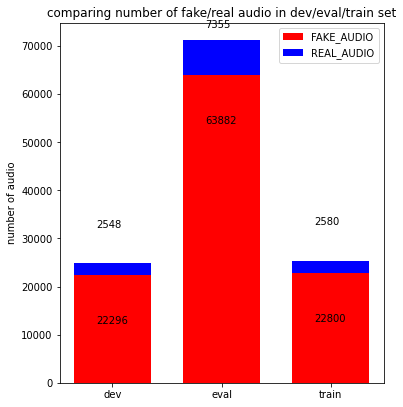

In [12]:
N=3
FAKE_AUDIO = (NUMBER_OF_FAKE_AUDIO_dev, NUMBER_OF_FAKE_AUDIO_eval, NUMBER_OF_FAKE_AUDIO_train)
REAL_AUDIO = (NUMBER_OF_REAL_AUDIO_dev, NUMBER_OF_REAL_AUDIO_eval, NUMBER_OF_REAL_AUDIO_train)
ind = np.arange(N) 
fig = plt.figure()
ax = fig.add_axes([0,0,0.75,1.25])
ax.bar(ind, FAKE_AUDIO, color='r',tick_label = ['dev','eval','train'],width = 0.7)
ax.bar(ind, REAL_AUDIO,bottom=FAKE_AUDIO, color='b',width = 0.7)
ax.set_ylabel('number of audio')
ax.set_title('comparing number of fake/real audio in dev/eval/train set')
ax.legend(labels=['FAKE_AUDIO', 'REAL_AUDIO'])
for i in range(3):
  plt.text(x = ind[i]-0.15 , y = FAKE_AUDIO[i]-10000, s = FAKE_AUDIO  [i], size = 10)
  plt.text(x = ind[i]-0.15 , y = FAKE_AUDIO[i]+10000, s = REAL_AUDIO [i], size = 10)
plt.show()

analayzing the length disterbution of audio file in each dataframe


*   file with duration less than 1 sec - will get padding of zeros until they will become 1 sec long 

*   file with duration more than 1 sec - the most important 1 sec will pass to the NET






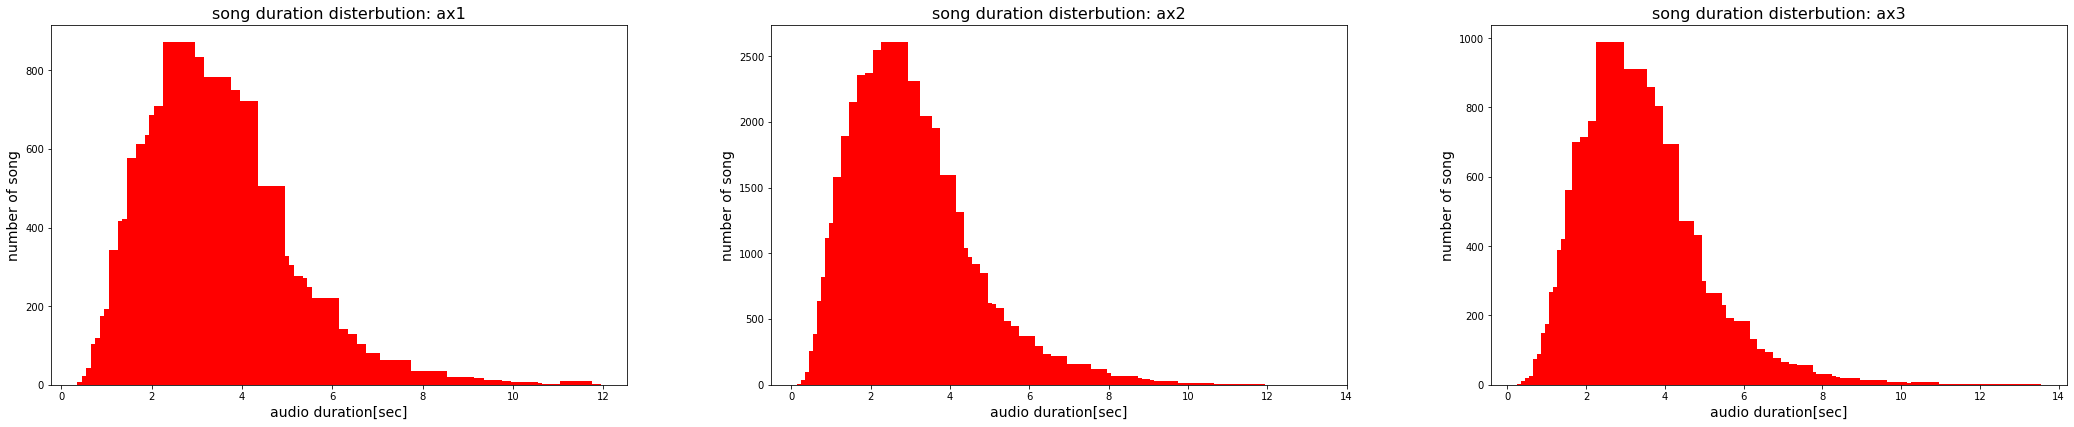

In [13]:
dataframes = [df_dev, df_eval, df_train]
ax1 = fig.add_subplot(1,3,1)
ax2 = fig.add_subplot(1,3,2)
ax3 = fig.add_subplot(1,3,3)
axss = [ax1, ax2, ax3]
axs_str = ["ax1", "ax2", "ax3"]
fig1 = plt.figure(figsize=(10,5))
q = 0
for data_frame in dataframes:
  duration_dict ={}
  duration_dict = dict.fromkeys(set(round((data_frame["duration"]),1)),0)
  for i in range(len(data_frame)):
    duration_dict[round((data_frame["duration"][i]),1)] +=1 
  axss[q] = fig1.add_axes([q,0,0.8,1.0])
  axss[q].bar(list(duration_dict.keys()),list(duration_dict.values()) , color='r',width = 0.7)
  axss[q].set_ylabel('number of song',size=14)
  axss[q].set_xlabel('audio duration[sec]',size=14)
  axss[q].set_title('song duration disterbution: '+axs_str[q], size=16)
  q+=1
plt.show()

In [14]:
# audio_array, sr_1 = train_set.audio_data(4)
# time = np.arange(0,len(audio_array))/sr_1
# fig, ax = plt.subplots()
# ax.plot(time, audio_array)
# ax.set(xlabel='time(sec)', ylabel='sound Amplitude', title="full length audio")
# plt.show()

get the most important 1 sec in the audio file

In [15]:
# audio_array = train_set.get_1_sec(4)
# time = np.arange(0,len(audio_array))/22050
# fig, ax = plt.subplots()
# ax.plot(time, audio_array)
# ax.set(xlabel='time(s)', ylabel='sound Amplitude', title="most importent 1 sec in the audio")
# plt.show()

### histogram

In [16]:
first_audio_data, first_audio_sample_rate = librosa.load("LA/train_wav/LA_T_1000137.wav", sr=22050, mono=True)

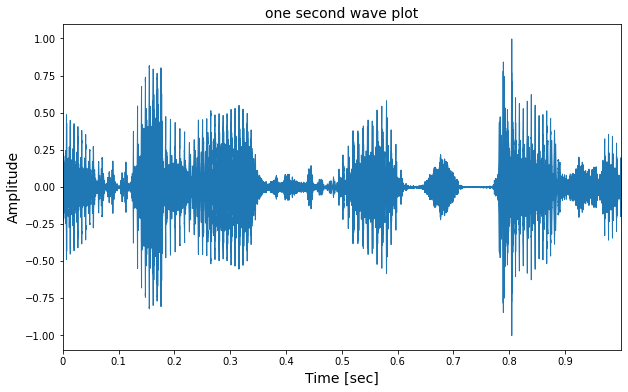

In [17]:
plt.figure(figsize=(10,6))
librosa.display.waveplot(first_audio_data, first_audio_sample_rate)
plt.title("one second wave plot", fontsize=14)
plt.xlabel("Time [sec]", fontsize=14)
plt.ylabel("Amplitude", fontsize=14)
plt.show()

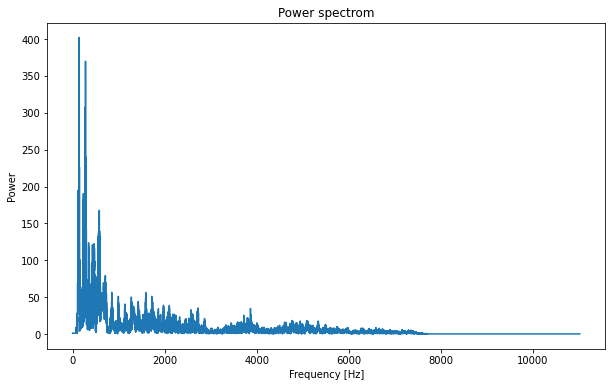

In [18]:
fft = np.fft.fft(first_audio_data)
magnitude = np.abs(fft)
left_magnitude = magnitude[:int(len(magnitude)/2)]
frequency = np.linspace(0, first_audio_sample_rate, len(magnitude))
left_frequency = frequency[:int(len(frequency)/2)]
plt.figure(figsize=(10,6))
plt.plot(left_frequency,left_magnitude)
plt.xlabel("Frequency [Hz]")
plt.ylabel("Power")
plt.title("Power spectrom")
plt.show()

## Short Time Fourier Transform - STFT - visualization
computes several FFT at different intervals

preserves time information

(1025, 87)


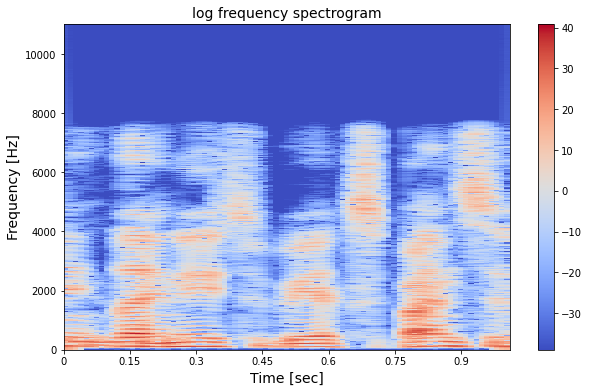

In [19]:
n_fft = 2048 # outpot shape: (1025, 190)
hop_length = 256
stft = librosa.core.stft(first_audio_data, hop_length=hop_length, n_fft=n_fft)
print(stft.shape)
plt.figure(figsize=(10,6))
spectrogran = np.abs(stft)
log_spectogram = librosa.amplitude_to_db(spectrogran)
librosa.display.specshow(log_spectogram, sr=first_audio_sample_rate, hop_length=hop_length, x_axis="time", y_axis="linear")
plt.title("log frequency spectrogram", fontsize=14)
plt.xlabel("Time [sec]", fontsize=14) 
plt.ylabel("Frequency [Hz]", fontsize=14)
plt.colorbar()
plt.show()

(1025, 44)


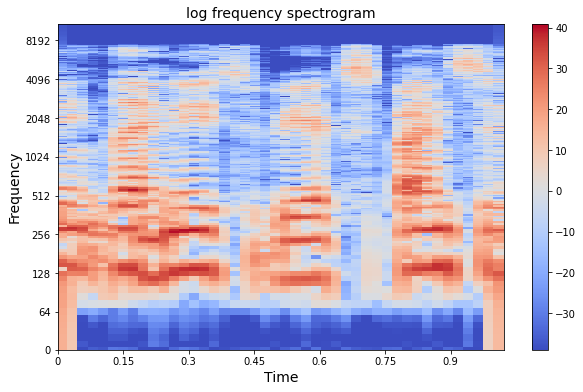

In [20]:
n_fft = 2048 # outpot shape: (1025, 190)
hop_length = 512
stft = librosa.core.stft(first_audio_data, hop_length=hop_length, n_fft=n_fft)
print(stft.shape)
plt.figure(figsize=(10,6))
spectrogran = np.abs(stft)
log_spectogram = librosa.amplitude_to_db(spectrogran)
a = librosa.display.specshow(log_spectogram, sr=first_audio_sample_rate, hop_length=hop_length, x_axis="time", y_axis="log")
plt.title("log frequency spectrogram", fontsize=14)
plt.xlabel("Time", fontsize=14) 
plt.ylabel("Frequency", fontsize=14)
plt.colorbar()
plt.show()

In [21]:
a

# Mel Spectrogram - visualization

n_fft = framesize

Mel filter banks shape = M = (#bands, framesize/2+1)

spectrogram shape = Y = (framesize/2+1, #frames)

applying Mel filter bank on spectrogram in matrix multiplication

Mel spectrogram = M*Y with shape (#bands, #frames)

**extract the triangle filters bank**

(13, 257)


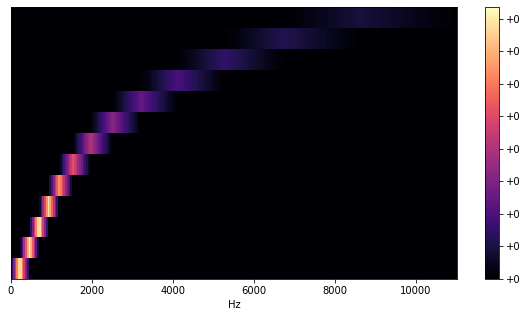

In [22]:
n_mels = 13
filter_banks = librosa.filters.mel(n_fft=512, sr=22050, n_mels= n_mels)
print(filter_banks.shape)
plt.figure(figsize=(10,5))
librosa.display.specshow(filter_banks, sr=22050, x_axis="linear")
plt.colorbar(format="%+2.f")
plt.show()

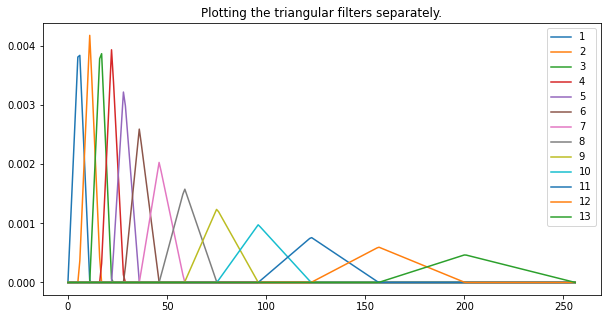

In [23]:
plt.figure(figsize=(10,5))
idxs_to_plot = list(range(0,n_mels,1))
for i in idxs_to_plot:
    plt.plot(filter_banks[i]);
plt.legend(labels=[f'{i+1}' for i in idxs_to_plot]);
plt.title('Plotting the triangular filters separately.');

**extract the Mel Spectrogram**

(13, 44)


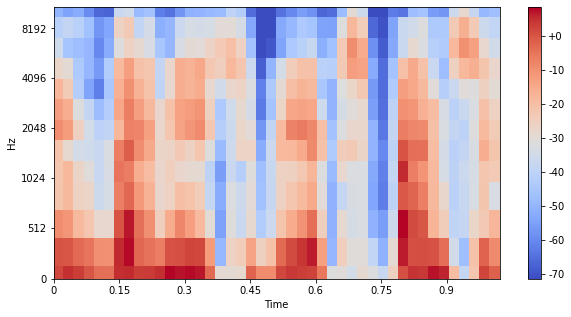

In [24]:
mel_spectrogram = librosa.feature.melspectrogram(first_audio_data, sr=22050, n_fft=512,n_mels=13) #512
print(mel_spectrogram.shape)
log_mel_spectrogram = librosa.power_to_db(mel_spectrogram)
plt.figure(figsize=(10,5))
librosa.display.specshow(log_mel_spectrogram, sr=22050, x_axis="time", y_axis="mel")
plt.colorbar(format="%+2.f")
plt.show()


# Mel Frequency Cepstral Coefficients - MFCCs -visualization

https://www.youtube.com/watch?v=4_SH2nfbQZ8&list=PL-wATfeyAMNqIee7cH3q1bh4QJFAaeNv0&index=19&ab_channel=ValerioVelardo-TheSoundofAI

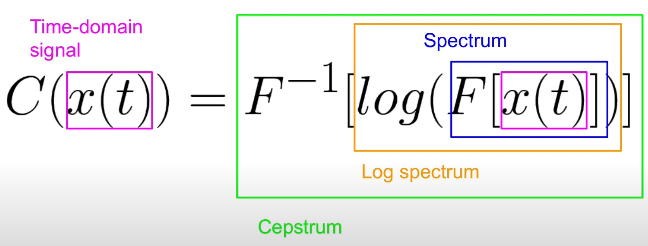

**extract the MFCC**

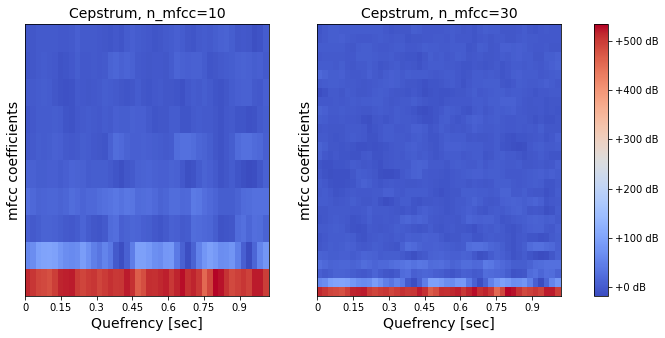

shape of MFCC 1 is: ( 10 x 44 )
shape of MFCC 2 is: ( 30 x 44 )


In [25]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(12,5), sharex=True)
n_mfcc1 = 10 #number of Feature in the mfcc 
n_mfcc2 = 30
MFFCs1 = librosa.feature.mfcc(librosa.power_to_db(first_audio_data), hop_length=hop_length, n_fft=n_fft, n_mfcc=n_mfcc1)
MFFCs2 = librosa.feature.mfcc(librosa.power_to_db(first_audio_data), hop_length=hop_length, n_fft=n_fft, n_mfcc=n_mfcc2)
img1 = librosa.display.specshow(MFFCs1, sr=first_audio_sample_rate, hop_length=hop_length, ax=ax[0],x_axis='time')
img2 = librosa.display.specshow(MFFCs2, sr=first_audio_sample_rate, hop_length=hop_length, ax=ax[1],x_axis='time')

fig.colorbar(img1, ax=ax, format="%+2.f dB")
ax[0].set_title('Cepstrum, n_mfcc=10', fontsize=14)
ax[1].set_title('Cepstrum, n_mfcc=30', fontsize=14)
ax[0].set_ylabel('mfcc coefficients', fontsize=14)
ax[1].set_ylabel('mfcc coefficients', fontsize=14)
ax[0].set_xlabel('Quefrency [sec]', fontsize=14)
ax[1].set_xlabel('Quefrency [sec]', fontsize=14) 
plt.show()
print("shape of MFCC 1 is: (",len(MFFCs1),"x",len(MFFCs1[0]),")")
print("shape of MFCC 2 is: (",len(MFFCs2),"x",len(MFFCs2[0]),")")

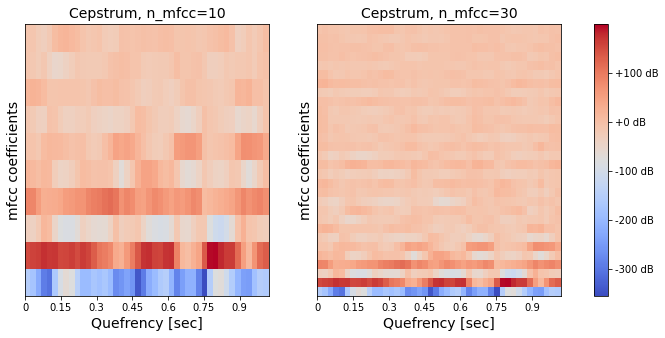

shape of MFCC 1 is: ( 10 x 44 )
shape of MFCC 2 is: ( 30 x 44 )


In [26]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(12,5), sharex=True)
n_mfcc1 = 10 #number of Feature in the mfcc 
n_mfcc2 = 30
MFFCs1 = librosa.feature.mfcc(first_audio_data, sr=22050, n_mfcc=n_mfcc1)
MFFCs2 = librosa.feature.mfcc(first_audio_data, sr=22050, n_mfcc=n_mfcc2)
img1 = librosa.display.specshow(MFFCs1, sr=first_audio_sample_rate, hop_length=hop_length, ax=ax[0],x_axis='time')
img2 = librosa.display.specshow(MFFCs2, sr=first_audio_sample_rate, hop_length=hop_length, ax=ax[1],x_axis='time')

fig.colorbar(img1, ax=ax, format="%+2.f dB")
ax[0].set_title('Cepstrum, n_mfcc=10', fontsize=14)
ax[1].set_title('Cepstrum, n_mfcc=30', fontsize=14)
ax[0].set_ylabel('mfcc coefficients', fontsize=14)
ax[1].set_ylabel('mfcc coefficients', fontsize=14)
ax[0].set_xlabel('Quefrency [sec]', fontsize=14)
ax[1].set_xlabel('Quefrency [sec]', fontsize=14) 
plt.show()
print("shape of MFCC 1 is: (",len(MFFCs1),"x",len(MFFCs1[0]),")")
print("shape of MFCC 2 is: (",len(MFFCs2),"x",len(MFFCs2[0]),")")

**delta MFCC**

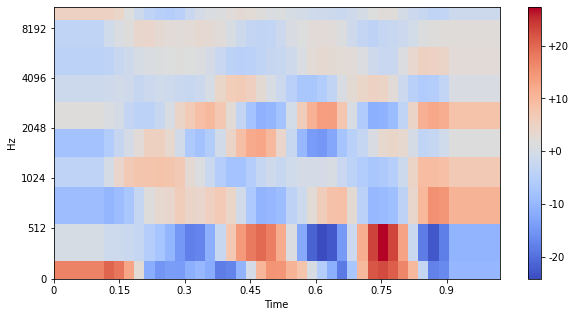

(10, 44)


In [27]:
delta_mfcc = librosa.feature.delta(MFFCs1)
plt.figure(figsize=(10,5))
librosa.display.specshow(delta_mfcc, sr=22050, x_axis="time", y_axis="mel")
plt.colorbar(format="%+2.f")
plt.show()
print(delta_mfcc.shape)

**delta delta mfcc**

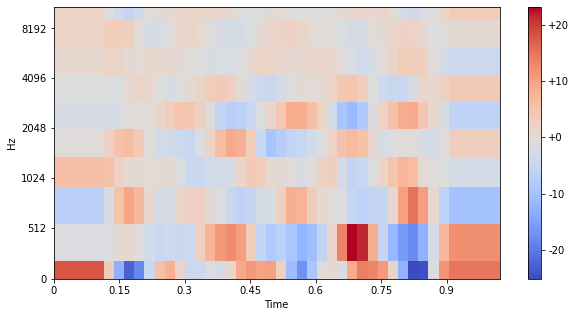

(10, 44)


In [28]:
delta_mfcc2 = librosa.feature.delta(MFFCs1,order=2)
plt.figure(figsize=(10,5))
librosa.display.specshow(delta_mfcc2, sr=22050, x_axis="time", y_axis="mel")
plt.colorbar(format="%+2.f")
plt.show()
print(delta_mfcc2.shape)

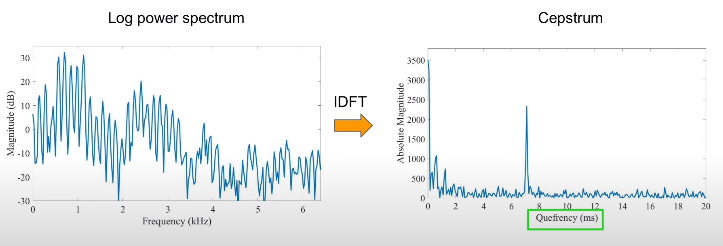

# **utility function**

**weight for balance data sampeler**

In [29]:
def make_keyys(dataframe):
  keyss = []
  for x in dataframe.KEY:
    if x == "bonafide":
      keyss.append(1)
    elif x == "spoof":
      keyss.append(0)
    else:
      print("Error: ",x)
  return keyss

def make_weights_for_balanced_classes(labels, number_of_classes):                        
    count = [0] * number_of_classes                                                      
    for label in labels:                                                         
      count[label] += 1                                                     
    weight_per_class = [0.] * number_of_classes                                      
    N = float(sum(count))                                                   
    for i in range(number_of_classes):                                                   
        weight_per_class[i] = N/float(count[i])                                 
    weight = [0] * len(labels)                                              
    for idx, val in enumerate(labels):                                          
        weight[idx] = round(weight_per_class[val]/10,5)                                  
    return weight   

 **number of correct prediction out of all prediction**

In [30]:
def get_num_correct(preds, labels):
  correct = 0
  preds =preds.squeeze()
  labels =labels.squeeze()
  if len(preds)!=len(labels):
    print("ERROR - pread and labels are not in the same length")
  for i in range(len(preds)):
    if torch.round(preds[i]) == labels[i]:
      correct += 1
  return correct

  **Confusion Matrix**

In [31]:
# 'spoof'=0
# 'bonafide' = 1
def conf_matrix(preds, labels):
  preds =torch.round(preds.squeeze())
  stacked = torch.stack((preds,labels),dim=1)
  cmt =  torch.zeros(2,2, dtype=torch.int64)
  for p in stacked:
    j,k = p.tolist()
    j=int(j)
    k=int(k)
    cmt[j,k] =cmt[j,k]+1
  print("\n",cmt) 
  names = ("spoof - 0", "bonafid - 1")
  plt.figure(figsize = (8,6))
  sn.heatmap(cmt,cmap= "YlGnBu", annot=True, fmt ="d",yticklabels=names ,xticklabels=names, annot_kws={"size": 14})
  plt.title("Confusion matrix", fontsize=16)
  plt.xlabel('Actual', fontsize=16)
  plt.ylabel('Predicted', fontsize=16)
  plt.show()

# **STFT**

In [32]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sn

In [33]:
%load_ext tensorboard
%matplotlib inline
from torch.utils.tensorboard import SummaryWriter
import datetime

In [34]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Running on:",device)

Running on: cpu


## STFT dataset class



In [35]:
class my_Dataset(Dataset):
  def __init__(self,data_frame, flac_path):
    self.data_frame = data_frame
    self.flac_path = flac_path
    self.SPEAKER_ID = data_frame["SPEAKER_ID"]
    self.AUDIO_FILE_NAME = data_frame["AUDIO_FILE_NAME"]
    self.KEY = data_frame["KEY"]
  
  def __getitem__(self, i): #call an item by index
    if self.KEY[i] == 'bonafide':
      bool_val = torch.tensor(1, dtype=torch.float32)
    elif self.KEY[i] =='spoof':
      bool_val = torch.tensor(0, dtype=torch.float32)
    else:
      print("Ereor: ",self.AUDIO_FILE_NAME[i])
    return bool_val, torch.tensor(self.stft(i), dtype=torch.float32)   #self.AUDIO_FILE_NAME[i] ,

  def __len__(self): # how many records are in the dateset
    return len(self.data_frame)

  def audio_data(self,i, play_sound=False):
    audio_file_path = self.flac_path +"/" + self.AUDIO_FILE_NAME[i] + ".wav" #".flac"
    signal, sr = librosa.load(path=audio_file_path)
    if (len(signal)/sr)<1.00:
      signal =np.pad(signal,(0,sr-len(signal)),"constant")
    return librosa.util.normalize(signal), sr 

  def duration(self,audio_index): #return the loadet 1 second from the audio data
    sound_data,sample_rate = self.audio_data(audio_index)
    return round((len(sound_data)/sample_rate),2)

  def get_1_sec(self,audio_index): #return the loadet 1 second from the audio data
    sound_data,sample_rate = self.audio_data(audio_index)
    sum_of_sq = []
    # if (len(sound_data)/sample_rate)<1.0:
    #   raise ValueError("audio is shorter then 1 sec", self[audio_index])
    step = 1000 
    max_arg = 0
    for i in range(0,len(sound_data)-sample_rate,step):
      sum_of_sq.append(np.trapz(abs(sound_data[i:(i+sample_rate):100])))
      max_arg = step*(np.argmax(sum_of_sq))
    return sound_data[max_arg : max_arg+sample_rate]

  def stft(self,i, show_hist=False):
    n_fft = 2048
    hop_length = 128
    stft = librosa.core.stft(self.audio_data(i)[0], hop_length=hop_length, n_fft=n_fft) #self.get_1_sec(i)
    spectrogran = np.abs(stft)
    return librosa.util.normalize(librosa.amplitude_to_db(spectrogran))

In [36]:
train_set = my_Dataset(df_train,"LA/train_wav")
print("number of audio track in Dataset: ",len(train_set))

number of audio track in Dataset:  25380


## STFT net

In [37]:
class STFT_TO_CNN_NET(nn.Module):
  def __init__(self):
    super(STFT_TO_CNN_NET, self).__init__()
    self.conv1 = nn.Conv2d(1,10, kernel_size=5)
    self.conv2 = nn.Conv2d(10,20, kernel_size=5)
    self.conv3 = nn.Conv2d(20,30, kernel_size=5)
    self.conv4 = nn.Conv2d(30,30, kernel_size=5)
    self.mp = nn.MaxPool2d(2)

    x = torch.randn(1025, 173).view(-1,1,1025, 173) #44, 354
    self._to_linear = None 
    self.convs(x)

    self.fc1 = nn.Linear(self._to_linear,32)
    self.fc2 = nn.Linear(32,64)
    self.fc3 = nn.Linear(64,16)
    self.out = nn.Linear(16,1)
    self.dropout = nn.Dropout(0.3)

  def convs(self, x):
    # x = F.relu(self.conv1(x))
    # x = F.relu(self.conv2(x))
    # x = F.relu(self.conv3(x))
    x = F.max_pool2d(F.relu(self.conv1(x)), (2,2))
    x = F.max_pool2d(F.relu(self.conv2(x)), (2,2))
    x = F.max_pool2d(F.relu(self.conv3(x)), (2,2))
    x = F.max_pool2d(F.relu(self.conv4(x)), (2,2))

    if self._to_linear is None:
      self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
    return x

  def forward(self, x):
    x = self.convs(x)
    x = x.view(-1, self._to_linear)
    x =F.relu(self.fc1(x)) 
    x = self.dropout(x)
    x =F.relu(self.fc2(x))
    x = self.dropout(x)
    x =F.relu(self.fc3(x))
    x = torch.sigmoid(self.out(x))
    return x
stft_net = STFT_TO_CNN_NET().to(device)
BATCH_SIZE = 100

## stft loader

**train loader**

In [38]:

# train_set = my_Dataset(df_eval,"LA/eval_wav")
# train_set_weight =make_weights_for_balanced_classes(make_keyys(df_eval),number_of_classes=2)
train_set = my_Dataset(df_train,"LA/train_wav")
train_set_weight =make_weights_for_balanced_classes(make_keyys(df_train),number_of_classes=2)
train_sampler = torch.utils.data.sampler.WeightedRandomSampler(train_set_weight,len(train_set))#balancing the train set categories
train_loader = DataLoader(dataset=train_set,
                          batch_size=BATCH_SIZE,
                          shuffle=False,
                          num_workers=0,
                          sampler=train_sampler)
# data = iter(train_loader)
# train_labels, train_stft = data.next()  
# print(train_stft.shape, len(train_labels))

**validation loader**

In [39]:
validation_set = my_Dataset(df_dev,"LA/dev_wav")
validation_set_weight =make_weights_for_balanced_classes(make_keyys(df_dev),number_of_classes=2)
validation_sampler = torch.utils.data.sampler.WeightedRandomSampler(validation_set_weight,len(validation_set))#balancing the validation_set set categories
validation_loader = DataLoader(dataset=validation_set,
                          batch_size=BATCH_SIZE,
                          shuffle=False,
                          num_workers=0,
                          sampler=validation_sampler)
validation_data = iter(validation_loader)

**STFT training loop**

In [40]:
def train_STFT_net():
  num_epochs = 4
  current_time = datetime.datetime.now().strftime("%m.%d-%H:%M ")
  comment = "dropout(0.3,0.3), lr=0.001, 3CNN, 3fully_layer, batch_size=100, hop_length=128, on test "
  print("current time: ", current_time)
  logs_train_dir = os.path.join("drive/MyDrive/LA/logs_STFT", current_time+comment)
  %tensorboard --logdir=drive/MyDrive/LA/logs_STFT
  train_writer = SummaryWriter(logs_train_dir+"train")
  val_writer = SummaryWriter(logs_train_dir+"val")
  train_labels, train_stft = next(iter(train_loader))
  train_stft, train_labels =train_stft.to(device), train_labels.to(device)
  train_writer.add_graph(stft_net,train_stft.unsqueeze(1))
  train_writer.flush()
  optimizer = optim.Adam(stft_net.parameters(), lr=0.001)
  validation_acc = 0.5
  best_validation_acc = 0.85
  validation_loss = 1
  stft_net.train()

  for epoch in range(num_epochs):
    cumulative_loss = 0
    batch_preds = torch.tensor([])
    batch_labels = torch.tensor([])
    batch_preds, batch_labels = batch_preds.to(device),batch_labels.to(device)
    train_loop =  tqdm(enumerate(train_loader), total=len(train_loader), position=0,leave=True)
    for batch_index, (train_labels, train_stft) in train_loop:
      train_stft, train_labels =train_stft.to(device), train_labels.to(device)
      output = stft_net(train_stft.unsqueeze(1))
      optimizer.zero_grad() #clean old gradients 
      loss = F.binary_cross_entropy(output.squeeze(), train_labels)
      loss.backward() #Preform gradient descent, backwards pass
      optimizer.step() #Take a step in the right direction 
      batch_preds = torch.cat((batch_preds, output), dim=0)
      batch_labels = torch.cat((batch_labels, train_labels), dim=0)
      cumulative_loss += loss.item()
      absolute_index = batch_index+(epoch*(len(train_loader)))
      train_writer.add_scalar("Loss", loss, absolute_index)#save loss score to tensorboard
      train_writer.add_scalar("Accuracy", get_num_correct(output,train_labels)/BATCH_SIZE,  absolute_index)#save acc score to tensorboard
      train_loop.set_description(f"Epoch [{epoch+1}/{num_epochs}]") # update progress bar
      train_loop.set_postfix(loss = round(cumulative_loss/(batch_index+1),3), acc =(get_num_correct(batch_preds,batch_labels))/len(batch_labels), val_acc=validation_acc, val_loss=validation_loss) #, "number of currect:",get_num_correct(output, train_labels), "out of", str(BATCH_SIZE)
      if batch_index%10==1:
        with torch.no_grad():
          stft_net.eval()
          validation_labels, validation_stft = next(validation_data) 
          validation_labels, validation_stft = validation_labels.to(device), validation_stft.to(device)
          validation_output = stft_net(validation_stft.unsqueeze(1))
          validation_loss = F.binary_cross_entropy(validation_output.squeeze(), validation_labels)
          validation_loss = validation_loss.item()
          validation_acc = (get_num_correct(validation_output,validation_labels)/BATCH_SIZE)
          val_writer.add_scalar("Loss", validation_loss, absolute_index)
          val_writer.add_scalar("Accuracy", validation_acc,  absolute_index)
          val_writer.flush()
          stft_net.train()
      train_writer.flush()
    conf_matrix(batch_preds, batch_labels)
    if best_validation_acc < validation_acc: #save the model base on best dev_score in best epoch
      best_validation_acc = validation_acc 
      model_save_PATH = "drive/MyDrive/LA/logs_STFT/saved_model/"+current_time+comment+"best_acc "+str(round(best_validation_acc,2))+".pth" 
      torch.save(stft_net.state_dict(), model_save_PATH)         
  train_writer.flush()#make sure that all pending events have been written to disk
  train_writer.close()
  return model_save_PATH
# best_model_saved_path =  train_STFT_net()

In [41]:
# %tensorboard --logdir=drive/MyDrive/LA/logs_STFT

In [ ]:
# best_model_saved_path = "drive/MyDrive/LA/logs_STFT/saved_model/"+"02.27-11_36 dropout(0.3,0.3), lr=0.001,3CNN ,4fully_layer ,batch_size=100,hop_length = 128, best_acc 0.92.pth"
best_model_saved_path = "drive/MyDrive/LA/logs_STFT/saved_model/"+"02.27-11_36 dropout(0.3,0.3), lr=0.001,3CNN ,4fully_layer ,batch_size=100,hop_length = 128, best_acc 0.89.pth"
loaded_stft_net = STFT_TO_CNN_NET().to(device)
loaded_stft_net.load_state_dict(torch.load(best_model_saved_path))
print(best_model_saved_path)
loaded_stft_net.eval()

**test loop**

In [ ]:
test_set = my_Dataset(df_eval,"LA/eval_wav")
eval_set_weight =make_weights_for_balanced_classes(make_keyys(df_eval),2)#balancing the test set categories
eval_sampler = torch.utils.data.sampler.WeightedRandomSampler(eval_set_weight,len(test_set),replacement=False)
test_loader = DataLoader(dataset=test_set,
                          batch_size=BATCH_SIZE,
                          shuffle=False,
                          num_workers=0) #,sampler=eval_sampler
                          

In [ ]:
def test(net):
    correct = 0
    total = 0
    test_total_preds = torch.tensor([])
    test_total_labels = torch.tensor([])
    test_total_preds, test_total_labels = test_total_preds.to(device), test_total_labels.to(device)
    with torch.no_grad():
      test_loop =  tqdm(enumerate(test_loader), total=len(test_loader), position=0,leave=True)
      for batch_index, (test_labels, test_stft) in test_loop:
        if batch_index>10:
          break
        test_stft, test_labels =test_stft.to(device), test_labels.to(device)
        test_output = net(test_stft.unsqueeze(1))
        correct += get_num_correct(test_output,test_labels)
        total += len(test_labels)
        test_loop.set_postfix(acc = round(correct/total,3))
        test_total_preds = torch.cat((test_total_preds, test_output), dim=0)
        test_total_labels = torch.cat((test_total_labels, test_labels), dim=0) 
      print("\n","Accuracy:", round(correct/total,3))
      conf_matrix(test_total_preds, test_total_labels) 
      roc_carv(test_total_labels.to('cpu').numpy() ,test_total_preds.squeeze().to('cpu').numpy())
      #precision recall curve - need to add
      #print(classification_report(y_test, y_pred_list))
test(loaded_stft_net)

In [ ]:
import re
import io
# !pip install visdom
from visdom import Visdom
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

In [ ]:
def roc_carv(labels, preds):
  fpr, tpr, thresholds = roc_curve(labels,preds, pos_label=1)
  roc_auc = auc(fpr, tpr)
  plt.figure()
  lw = 2
  plt.plot(fpr, tpr, color='darkorange',
          lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
  plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic example')
  plt.legend(loc="lower right")
  plt.show()
  # labels = np.random.randint(0, 2, (10,))
  # scores = np.random.uniform(0, 1, (10,))
  # precision, recall, thresholds = precision_recall_curve(labels, preds)

  # fig, ax = plt.subplots()
  # ax.step(recall,precision,color='r',alpha=0.99,where='post')
  # ax.fill_between(recall, precision, alpha=0.2, color='b', step='post')
  # plt.xlabel('Recall')
  # plt.ylabel('Precision')
  # plt.ylim([0.0, 1.05])
  # plt.xlim([0.0, 1.0])
  # plt.show()
  # viz = Visdom()
  # imgdata = io.StringIO()
  # fig.savefig(imgdata, format='svg')

  # svg_str = imgdata.getvalue()
  # # Scale the figure
  # svg_str = re.sub('width=".*pt"', 'width="100%"', svg_str)
  # svg_str = re.sub('height=".*pt"', 'height="100%"', svg_str)
  # viz.svg(svg_str)

In [ ]:
stop

# **Mel Spectrogram**

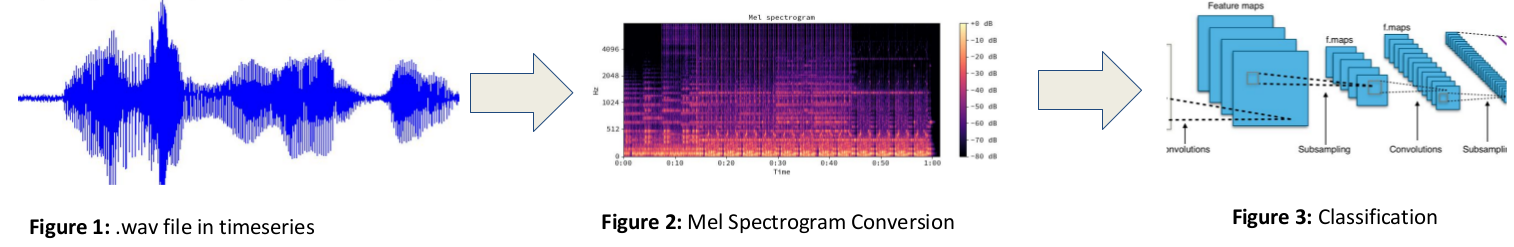

## Mel Spectrogram dataset class

In [ ]:
from torch.utils.data import Dataset, DataLoader
class MEl_SPEC_Dataset(Dataset):
  def __init__(self,data_frame, flac_path):
    self.data_frame = data_frame
    self.flac_path = flac_path
    self.SPEAKER_ID = data_frame["SPEAKER_ID"]
    self.AUDIO_FILE_NAME = data_frame["AUDIO_FILE_NAME"]
    self.KEY = data_frame["KEY"]
  
  def __getitem__(self, i): #call an item by index
    if self.KEY[i] == 'bonafide':
      bool_val = torch.tensor(1, dtype=torch.float32)
    elif self.KEY[i] =='spoof':
      bool_val = torch.tensor(0, dtype=torch.float32)
    else:
      print("Ereor: ",self.AUDIO_FILE_NAME[i])
    return  bool_val, torch.tensor(self.mel_spec(i), dtype=torch.float32)   #self.AUDIO_FILE_NAME[i] ,
    
  def __len__(self): # how many records are in the dateset
    return len(self.data_frame)

  def audio_data(self,i, play_sound=False):
    audio_file_path = self.flac_path +"/" + self.AUDIO_FILE_NAME[i] + ".wav"
    signal, sr = librosa.load(path=audio_file_path)
    if (len(signal)/sr)<1.00:
      signal =np.pad(signal,(0,sr-len(signal)),"constant")
    return librosa.util.normalize(signal), sr 

  def duration(self,audio_index): #return the loadet 1 second from the audio data
    sound_data,sample_rate = self.audio_data(audio_index)
    return round((len(sound_data)/sample_rate),2)

  def get_1_sec(self,audio_index): #return the loadet 1 second from the audio data
    sound_data,sample_rate = self.audio_data(audio_index)
    sum_of_sq = []
    step = 1000 
    max_arg = 0
    for i in range(0,len(sound_data)-sample_rate,step):
      sum_of_sq.append(np.trapz(abs(sound_data[i:(i+sample_rate):100])))
      max_arg = step*(np.argmax(sum_of_sq))
    return sound_data[max_arg : max_arg+sample_rate]

  def mel_spec(self,i, show_hist=False):
    mel_spectrogram = librosa.feature.melspectrogram(self.audio_data(i)[0], sr=22050, n_fft=2048, hop_length=128, n_mels=30) #512
    log_mel_spectrogram = librosa.power_to_db(mel_spectrogram)
    return librosa.util.normalize(log_mel_spectrogram)

In [ ]:
mel_spec_train_set = MEl_SPEC_Dataset(df_train,"LA/train_wav")
print("number of audio track in Dataset: ",len(mel_spec_train_set))

## Mel Spectrogram net

In [ ]:
class MEl_SPEC_TO_CNN_NET(nn.Module):
  def __init__(self):
    super(MEl_SPEC_TO_CNN_NET, self).__init__()
    self.conv1 = nn.Conv2d(1,10, kernel_size=3)
    self.conv2 = nn.Conv2d(10,20, kernel_size=3)
    self.conv3 = nn.Conv2d(20,30, kernel_size=3)
    self.mp = nn.MaxPool2d(2)

    x = torch.randn(30, 173).view(-1,1,30, 173)
    self._to_linear = None 
    self.convs(x)
    self.fc1 = nn.Linear(self._to_linear,32)
    self.fc2 = nn.Linear(32,60)
    self.fc3 = nn.Linear(60,16)
    self.out = nn.Linear(16,1)
    self.dropout = nn.Dropout(0.3)

  def convs(self, x):
    x = F.max_pool2d(F.relu(self.conv1(x)), (2,2))
    x = F.max_pool2d(F.relu(self.conv2(x)), (2,2))
    x = F.max_pool2d(F.relu(self.conv3(x)), (2,2))


    if self._to_linear is None:
      self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
    return x

  def forward(self, x):
    x = self.convs(x)
    x = x.view(-1, self._to_linear)
    x =F.relu(self.fc1(x)) 
    x = self.dropout(x)
    x =F.relu(self.fc2(x))
    x = self.dropout(x)
    x =F.relu(self.fc3(x))
    x = self.dropout(x)
    x = torch.sigmoid(self.out(x))
    return x
mel_spec_net = MEl_SPEC_TO_CNN_NET().to(device)
BATCH_SIZE = 100

## Mel Spectrogram dataloader

In [ ]:
mel_spec_train_set = MEl_SPEC_Dataset(df_train,"LA/train_wav")
mel_spec_train_set_weight =make_weights_for_balanced_classes(make_keyys(df_train),number_of_classes=2)
mel_spec_train_sampler = torch.utils.data.sampler.WeightedRandomSampler(mel_spec_train_set_weight,len(mel_spec_train_set))#balancing the train set categories
mel_spec_train_loader = DataLoader(dataset=mel_spec_train_set,
                          batch_size=BATCH_SIZE,
                          shuffle=False,
                          num_workers=0,
                          sampler=mel_spec_train_sampler)
# mel_spec_data = iter(mel_spec_train_loader)
# mel_spec_train_labels, train_mel_spec = mel_spec_data.next()  
# print(train_mel_spec.shape, len(mel_spec_train_labels))

In [ ]:
mel_spec_validation_set = MEl_SPEC_Dataset(df_dev,"LA/dev_wav")
mel_spec_validation_set_weight =make_weights_for_balanced_classes(make_keyys(df_dev),number_of_classes=2)
mel_spec_validation_sampler = torch.utils.data.sampler.WeightedRandomSampler(mel_spec_validation_set_weight,len(mel_spec_validation_set))#balancing the validation_set set categories
mel_spec_validation_loader = DataLoader(dataset=mel_spec_validation_set,
                          batch_size=BATCH_SIZE,
                          shuffle=False,
                          num_workers=0,
                          sampler=mel_spec_validation_sampler)
mel_spec_validation_data = iter(mel_spec_validation_loader)

## Mel Spectrogram trainig loop

In [ ]:
def train_MEl_SPEC_net():
  num_epochs = 5
  current_time = datetime.datetime.now().strftime("%m.%d-%H:%M ")
  comment = "2dropout(0.3,0.3)-lr=0.001-3CNN-kern=3,n_fft=512,n_mfcc = 30, "
  print("current time: ", current_time)
  logs_train_dir = os.path.join("drive/MyDrive/LA/logs_MEl_SPEC", current_time+comment)
  %tensorboard --logdir=drive/MyDrive/LA/logs_MEl_SPEC
  train_writer = SummaryWriter(logs_train_dir+"train")
  val_writer = SummaryWriter(logs_train_dir+"val")
  mel_spec_train_labels, train_mel_spec = next(iter(mel_spec_train_loader))
  train_mel_spec, mel_spec_train_labels =train_mel_spec.to(device), mel_spec_train_labels.to(device)
  train_writer.add_graph(mel_spec_net,train_mel_spec.unsqueeze(1))
  train_writer.flush()
  optimizer = optim.Adam(mel_spec_net.parameters(), lr=0.001)
  validation_acc = 0.5
  best_validation_acc = 0.80
  validation_loss = 1
  mel_spec_net.train()

  for epoch in range(num_epochs):
    cumulative_loss = 0
    batch_preds = torch.tensor([])
    batch_labels = torch.tensor([])
    batch_preds, batch_labels = batch_preds.to(device),batch_labels.to(device)
    train_loop =  tqdm(enumerate(mel_spec_train_loader), total=len(mel_spec_train_loader), position=0,leave=True)
    for batch_index, (mel_spec_train_labels, train_mel_spec) in train_loop:
      train_mel_spec, mel_spec_train_labels =train_mel_spec.to(device), mel_spec_train_labels.to(device)
      output = mel_spec_net(train_mel_spec.unsqueeze(1))
      optimizer.zero_grad() #clean old gradients 
      loss = F.binary_cross_entropy(output.squeeze(), mel_spec_train_labels)
      loss.backward() #Preform gradient descent, backwards pass
      optimizer.step() #Take a step in the right direction 
      batch_preds = torch.cat((batch_preds, output), dim=0)
      batch_labels = torch.cat((batch_labels, mel_spec_train_labels), dim=0)
      cumulative_loss += loss.item()
      absolute_index = batch_index+(epoch*(len(mel_spec_train_loader)))
      train_writer.add_scalar("Loss", loss, absolute_index)#save loss score to tensorboard
      train_writer.add_scalar("Accuracy", get_num_correct(output,mel_spec_train_labels)/BATCH_SIZE,  absolute_index)#save acc score to tensorboard
      train_loop.set_description(f"Epoch [{epoch+1}/{num_epochs}]") # update progress bar
      train_loop.set_postfix(loss = round(cumulative_loss/(batch_index+1),3), acc =(get_num_correct(batch_preds,batch_labels))/len(batch_labels), val_acc=validation_acc, val_loss=validation_loss) #, "number of currect:",get_num_correct(output, train_labels), "out of", str(BATCH_SIZE)
      if batch_index%10==1:
        with torch.no_grad():
          mel_spec_net.eval()
          validation_labels, validation_mel_spec = next(mel_spec_validation_data) 
          validation_labels, validation_mel_spec = validation_labels.to(device), validation_mel_spec.to(device)
          validation_output = mel_spec_net(validation_mel_spec.unsqueeze(1))
          validation_loss = F.binary_cross_entropy(validation_output.squeeze(), validation_labels)
          validation_loss = validation_loss.item()
          validation_acc = (get_num_correct(validation_output,validation_labels)/BATCH_SIZE)
          val_writer.add_scalar("Loss", validation_loss, absolute_index)
          val_writer.add_scalar("Accuracy", validation_acc,  absolute_index)
          val_writer.flush()
          mel_spec_net.train()
      train_writer.flush()
    conf_matrix(batch_preds, batch_labels)
    if best_validation_acc < validation_acc: #save the model base on best dev_score in best epoch
      best_validation_acc = validation_acc 
      model_save_PATH = "drive/MyDrive/LA/logs_MEL_SPEC/saved_model/"+comment+current_time+"best_acc"+str(best_validation_acc)+".pth" 
      torch.save(mel_spec_net.state_dict(), model_save_PATH)         
  train_writer.flush()#make sure that all pending events have been written to disk
  train_writer.close()
  return model_save_PATH
# best_mef_spec_model_saved_path = train_MEl_SPEC_net()

In [ ]:
# %tensorboard --logdir=drive/MyDrive/LA/logs_MEl_SPEC

In [ ]:
mel_spec_loaded_stft_net = MEl_SPEC_TO_CNN_NET().to(device)
mel_spec_loaded_stft_net.load_state_dict(torch.load(best_mef_spec_model_saved_path))
print(best_mef_spec_model_saved_path)
mel_spec_loaded_stft_net.eval()

In [ ]:
mel_spec_test_set = my_Dataset(df_eval,"LA/eval_wav")
mel_spec_eval_set_weight =make_weights_for_balanced_classes(make_keyys(df_eval),2)#balancing the test set categories
mel_spec_eval_sampler = torch.utils.data.sampler.WeightedRandomSampler(mel_spec_eval_set_weight,len(test_set))
test_loader = DataLoader(dataset=test_set,
                          batch_size=BATCH_SIZE,
                          shuffle=False,
                          num_workers=0,
                          sampler=mel_spec_eval_sampler)

In [ ]:
def mel_spec_test(net):
    correct = 0
    total = 0
    test_total_preds = torch.tensor([])
    test_total_labels = torch.tensor([])
    test_total_preds, test_total_labels = test_total_preds.to(device), test_total_labels.to(device)
    with torch.no_grad():
      test_loop =  tqdm(enumerate(mel_spec_test_loader), total=len(mel_spec_test_loader), position=0,leave=True)
      for batch_index, (test_labels, test_stft) in test_loop:
        if batch_index>200:
          break
        test_stft, test_labels =test_stft.to(device), test_labels.to(device)
        test_output = net(test_stft.unsqueeze(1))
        correct += get_num_correct(test_output,test_labels)
        total += len(test_labels)
        test_loop.set_postfix(acc = round(correct/total,3))
        test_total_preds = torch.cat((test_total_preds, test_output), dim=0)
        test_total_labels = torch.cat((test_total_labels, test_labels), dim=0)
      print("\n","Accuracy:", round(correct/total,3))
      conf_matrix(test_total_preds, test_total_labels)  
      #precision recall curve - need to add
      #print(classification_report(y_test, y_pred_list))
# mel_spec_test(loaded_stft_net)

In [ ]:
stop

# **MFCC**

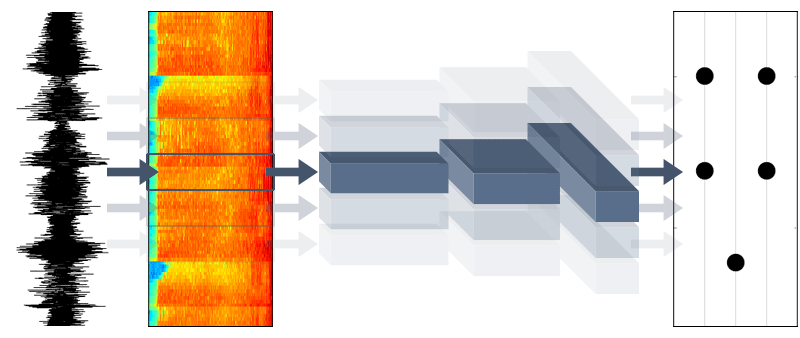

## MFCC dataset class

In [ ]:
from torch.utils.data import Dataset, DataLoader
class my_MFCC_Dataset(Dataset):
  def __init__(self,data_frame, flac_path):
    self.data_frame = data_frame
    self.flac_path = flac_path
    self.SPEAKER_ID = data_frame["SPEAKER_ID"]
    self.AUDIO_FILE_NAME = data_frame["AUDIO_FILE_NAME"]
    self.KEY = data_frame["KEY"]
  
  def __getitem__(self, i): #call an item by index
    if self.KEY[i] == 'bonafide':
      bool_val = torch.tensor(1, dtype=torch.float32)
    elif self.KEY[i] =='spoof':
      bool_val = torch.tensor(0, dtype=torch.float32)
    else:
      print("Ereor: ",self.AUDIO_FILE_NAME[i])
    return  bool_val, torch.tensor(self.mfcc(i), dtype=torch.float32)   #self.AUDIO_FILE_NAME[i] ,
    
  def __len__(self): # how many records are in the dateset
    return len(self.data_frame)

  def audio_data(self,i, play_sound=False):
    audio_file_path = self.flac_path +"/" + self.AUDIO_FILE_NAME[i] + ".flac"
    signal, sr = librosa.load(path=audio_file_path)
    if (len(signal)/sr)<1.00:
      signal =np.pad(signal,(0,sr-len(signal)),"constant")
    return librosa.util.normalize(signal), sr 

  def duration(self,audio_index): #return the loadet 1 second from the audio data
    sound_data,sample_rate = self.audio_data(audio_index)
    return round((len(sound_data)/sample_rate),2)

  def get_1_sec(self,audio_index): #return the loadet 1 second from the audio data
    sound_data,sample_rate = self.audio_data(audio_index)
    sum_of_sq = []
    # if (len(sound_data)/sample_rate)<1.0:
    #   raise ValueError("audio is shorter then 1 sec", self[audio_index])
    step = 1000 
    max_arg = 0
    for i in range(0,len(sound_data)-sample_rate,step):
      sum_of_sq.append(np.trapz(abs(sound_data[i:(i+sample_rate):100])))
      max_arg = step*(np.argmax(sum_of_sq))
    return sound_data[max_arg : max_arg+sample_rate]

  def mfcc(self,i, show_hist=False):
    hop_length = 128
    n_fft = 512
    n_mfcc = 30
    sr = self.audio_data(i)[1]
    MFFCs1 = librosa.feature.mfcc(librosa.power_to_db(self.audio_data(i)[0]),sr=22050, hop_length=hop_length, n_fft=n_fft, n_mfcc=n_mfcc)
    return MFCC_coefficients

In [ ]:
mfcc_train_set = my_MFCC_Dataset(df_train,"LA/train_flac")
print("number of audio track in Dataset: ",len(mfcc_train_set))

In [ ]:
stop

## MFCC net

In [ ]:
class MFCC_TO_CNN_NET(nn.Module):
  def __init__(self):
    super(MFCC_TO_CNN_NET, self).__init__()
    self.conv1 = nn.Conv2d(1,10, kernel_size=3)
    self.conv2 = nn.Conv2d(10,20, kernel_size=3)
    self.conv3 = nn.Conv2d(20,30, kernel_size=3)
    self.mp = nn.MaxPool2d(2)

    x = torch.randn(30, 257).view(-1,1,30, 257)
    self._to_linear = None 
    self.convs(x)

    self.fc1 = nn.Linear(self._to_linear,32)
    self.fc2 = nn.Linear(32,16)
    self.out = nn.Linear(16,1)
    self.dropout = nn.Dropout(0.3)

  def convs(self, x):
    # x = F.relu(self.conv1(x))
    # x = F.relu(self.conv2(x))
    # x = F.relu(self.conv3(x))
    x = F.max_pool2d(F.relu(self.conv1(x)), (2,2))
    x = F.max_pool2d(F.relu(self.conv2(x)), (2,2))
    x = F.max_pool2d(F.relu(self.conv3(x)), (2,2))

    if self._to_linear is None:
      self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
    return x

  def forward(self, x):
    x = self.convs(x)
    x = x.view(-1, self._to_linear)
    x =F.relu(self.fc1(x)) 
    x = self.dropout(x)
    x =F.relu(self.fc2(x))
    x = self.dropout(x)
    x = torch.sigmoid(self.out(x))
    return x
mfcc_net = MFCC_TO_CNN_NET().to(device)
BATCH_SIZE = 100

## MFCC dataloader

In [ ]:
mfcc_train_set = my_MFCC_Dataset(df_train,"LA/train_flac")
mfcc_train_set_weight =make_weights_for_balanced_classes(make_keyys(df_train),number_of_classes=2)
mfcc_train_sampler = torch.utils.data.sampler.WeightedRandomSampler(mfcc_train_set_weight,len(mfcc_train_set))#balancing the train set categories
mfcc_train_loader = DataLoader(dataset=mfcc_train_set,
                          batch_size=BATCH_SIZE,
                          shuffle=False,
                          num_workers=0,
                          sampler=mfcc_train_sampler)

In [ ]:
mfcc_validation_set = my_MFCC_Dataset(df_dev,"LA/dev_flac")
mfcc_validation_set_weight =make_weights_for_balanced_classes(make_keyys(df_dev),number_of_classes=2)
mfcc_validation_sampler = torch.utils.data.sampler.WeightedRandomSampler(mfcc_validation_set_weight,len(mfcc_validation_set))#balancing the validation_set set categories
mfcc_validation_loader = DataLoader(dataset=mfcc_validation_set,
                          batch_size=BATCH_SIZE,
                          shuffle=False,
                          num_workers=0,
                          sampler=mfcc_validation_sampler)
mfcc_validation_data = iter(mfcc_validation_loader)

## MFCC training loop

In [ ]:
def train_MFCC_net():
  num_epochs = 5
  current_time = datetime.datetime.now().strftime("%m.%d-%H:%M ")
  comment = "2dropout(0.3,0.3)-lr=0.001-3CNN-kern=3,n_fft=512,n_mfcc = 30, "
  print("current time: ", current_time)
  logs_train_dir = os.path.join("drive/MyDrive/LA/logs_MFCC", current_time+comment)
  %tensorboard --logdir=drive/MyDrive/LA/logs_MFCC
  train_writer = SummaryWriter(logs_train_dir+"train")
  val_writer = SummaryWriter(logs_train_dir+"val")
  mfcc_train_labels, train_mfcc = next(iter(mfcc_train_loader))
  train_mfcc, mfcc_train_labels =train_mfcc.to(device), mfcc_train_labels.to(device)
  train_writer.add_graph(mfcc_net,train_mfcc.unsqueeze(1))
  train_writer.flush()
  optimizer = optim.Adam(mfcc_net.parameters(), lr=0.001)
  validation_acc = 0.5
  best_validation_acc = 0.8
  validation_loss = 1
  mfcc_net.train()

  for epoch in range(num_epochs):
    cumulative_loss = 0
    batch_preds = torch.tensor([])
    batch_labels = torch.tensor([])
    batch_preds, batch_labels = batch_preds.to(device),batch_labels.to(device)
    train_loop =  tqdm(enumerate(mfcc_train_loader), total=len(mfcc_train_loader), position=0,leave=True)
    for batch_index, (mfcc_train_labels, train_mfcc) in train_loop:
      train_mfcc, mfcc_train_labels =train_mfcc.to(device), mfcc_train_labels.to(device)
      output = mfcc_net(train_mfcc.unsqueeze(1))
      optimizer.zero_grad() #clean old gradients 
      loss = F.binary_cross_entropy(output.squeeze(), mfcc_train_labels)
      loss.backward() #Preform gradient descent, backwards pass
      optimizer.step() #Take a step in the right direction 
      batch_preds = torch.cat((batch_preds, output), dim=0)
      batch_labels = torch.cat((batch_labels, mfcc_train_labels), dim=0)
      cumulative_loss += loss.item()
      absolute_index = batch_index+(epoch*(len(mfcc_train_loader)))
      train_writer.add_scalar("Loss", loss, absolute_index)#save loss score to tensorboard
      train_writer.add_scalar("Accuracy", get_num_correct(output,mfcc_train_labels)/BATCH_SIZE,  absolute_index)#save acc score to tensorboard
      train_loop.set_description(f"Epoch [{epoch+1}/{num_epochs}]") # update progress bar
      train_loop.set_postfix(loss = round(cumulative_loss/(batch_index+1),3), acc =(get_num_correct(batch_preds,batch_labels))/len(batch_labels), val_acc=validation_acc, val_loss=validation_loss) #, "number of currect:",get_num_correct(output, train_labels), "out of", str(BATCH_SIZE)
      if batch_index%10==1:
        with torch.no_grad():
          mfcc_net.eval()
          validation_labels, validation_mfcc = next(mfcc_validation_data) 
          validation_labels, validation_mfcc = validation_labels.to(device), validation_mfcc.to(device)
          validation_output = mfcc_net(validation_mfcc.unsqueeze(1))
          validation_loss = F.binary_cross_entropy(validation_output.squeeze(), validation_labels)
          validation_loss = validation_loss.item()
          validation_acc = (get_num_correct(validation_output,validation_labels)/BATCH_SIZE)
          val_writer.add_scalar("Loss", validation_loss, absolute_index)
          val_writer.add_scalar("Accuracy", validation_acc,  absolute_index)
          val_writer.flush()
          mfcc_net.train()
      train_writer.flush()
    conf_matrix(batch_preds, batch_labels)
    if best_validation_acc < validation_acc: #save the model base on best dev_score in best epoch
      best_validation_acc = validation_acc 
      model_save_PATH = "drive/MyDrive/LA/logs_MFCC/saved_model/"+comment+current_time+"best_acc"+str(best_validation_acc)+".pth" 
      torch.save(mfcc_net.state_dict(), model_save_PATH)         
  train_writer.flush()#make sure that all pending events have been written to disk
  train_writer.close()
train_MFCC_net()

In [ ]:
stop

# appendixes

### Pickel the dataframe 






save the durasion of each audio file in pandas df

In [ ]:
# files = df_eval["AUDIO_FILE_NAME"].values
# print("total_number of audio file:", len(files))
# start = time.time()
# for i in tqdm(range(len(files)),position=0):
#   data,sr = librosa.load("LA/eval_flac/flac/"+files[i]+".flac")
#   df_eval['duration'][i] = round((len(data)/sr),2)
# end = time.time()
# print(end - start)

save the start of the most emportent sec in audio file

In [ ]:
# import soundfile as sf
# for i in tqdm(range(len(df_dev))):
#   file_name = dev_set[i] 
#   audio_data = dev_set.get_1_sec(i)
#   PATH = "drive/MyDrive/LA/dev_wav4/" + file_name +".wav"
#   sf.write(PATH, audio_data, 22050)

In [ ]:
# start = time.time()
# df_eval.to_pickle("eval_df_pickled3", compression=None)
# end = time.time()
# print(end - start)

In [ ]:
# start = time.time()
# eval_dataframe_out  = pd.read_pickle("eval_df_pickled3")
# end = time.time()
# print(end - start)

In [ ]:
# eval_dataframe_out.head(10)

trainig two bacth - only for checking the network

In [ ]:
# train_labels, train_stft = data.next()
# train_stft, train_labels =train_stft.to(device), train_labels.to(device, dtype=torch.float32)
# train_labels = train_labels.view((BATCH_SIZE,1))
# optimizer = optim.Adam(stft_net.parameters(), lr=0.001)
# output = stft_net(train_stft.unsqueeze(1))
# loss = F.binary_cross_entropy(output, train_labels)
# loss.backward()
# optimizer.step()
# print(loss)
# print(get_num_correct(output, train_labels))
# train_labels, train_stft = data.next()
# train_stft, train_labels =train_stft.to(device), train_labels.to(device, dtype=torch.float32)
# output = stft_net(train_stft.unsqueeze(1))
# train_labels = train_labels.view((BATCH_SIZE,1))
# loss = F.binary_cross_entropy(output, train_labels)
# print(loss)
# print(get_num_correct(output, train_labels))

print net parameters

In [ ]:
# for name, param in stft_net.named_parameters(): # the parameter(tensors) of the network are on the device, not the network itself
#   print(param.device, "\t", name, "\t", param.shape)
# print("\n",stft_net)

**one iteration for expamle** 

In [ ]:
# train_labels, train_stft = data.next()  
# train_labels=train_labels.to(device)
# train_stft=train_stft.to(device)
# print(train_labels)
# print(train_stft.shape)
# print(len(train_labels))
# print("number of tensor with lable '1': ",sum(i == 1 for i in train_labels))
# print("number of tensor with lable '0': ",sum(i == 0 for i in train_labels))

clear gpu cache 

In [ ]:
# import gc 
# !nvidia-smi
# gc.collect() 
# torch.cuda.empty_cache()
# !nvidia-smi